## After collecting the data in the previous step, we will do text preprocessing in this step

In [1]:
!pip install transformers

### Import libraries

In [2]:
#Libraries for Text preprocessing 
import transformers 
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

#Normal computation libraries
import pandas as pd
import numpy as np

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

#Pytorch libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

#Set the Random Seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#Check for gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 49.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 113MB/s]


In [4]:
import warnings
warnings.simplefilter('ignore')

### Read the data

In [5]:
#Read the reviews
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [6]:
#We will remove the id for simplicity
# df.drop('reviewId', axis = 1, inplace = True)
# df.head()

In [7]:
#Get the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Text(0, 0.5, 'Score counts')

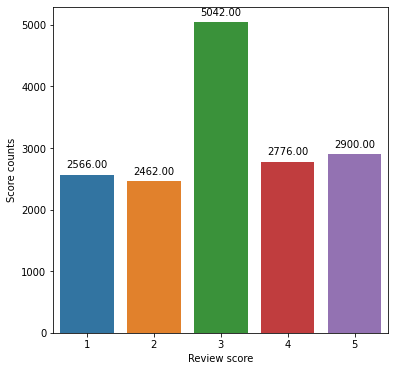

In [8]:
#We are interested in score, let's check the distribution
plt.rcParams['figure.figsize'] = 6, 6
review_count = sns.countplot(df.score)
for p in review_count.patches:
    review_count.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xlabel("Review score")
plt.ylabel("Score counts")

Convert the score to (4 and 5 to 2)positive, (1 and 2 to 0)negative and (3 to 1)neutral 

In [9]:
def convert_score_to_sentiment(rating):
    rating = int(rating)
    
    #If negative return 0 
    if rating < 3:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

In [10]:
#Add the new column named sentiment
df['sentiment'] = df['score'].apply(convert_score_to_sentiment)
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo,0
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo,0
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo,0
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo,0
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo,0


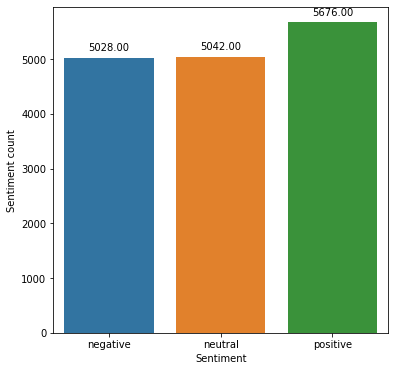

In [11]:
#Get the distribution of the sentiments
class_name = ['negative', 'neutral', 'positive']

sentiment_count = sns.countplot(df['sentiment'])
plt.xlabel('Sentiment')
plt.ylabel('Sentiment count')
sentiment_count.set_xticklabels(class_name)
for p in sentiment_count.patches:
    sentiment_count.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

The data seems balanced

### Data Preprocessing

We need to convert the text to numbers using tokenizer. For training data, BERT requires extra steps like
1. BERT needs special tokens indicating starting and ending of sentence, and special tokens for classification. 
2. The input must be of fixed length (padding for less tokens)
3. Create attention mask indicating importance of token

In [12]:
#Define the BERT Model
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'   #Cased better here for sentiment analysis might have more weight here

In [13]:
#Set the tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Perform a sample text analysis

In [14]:
#Create a sample sentence for analysis
sample = 'I love NLP. It is very interesting to play with words. Do you like NLP?'

#Get the tokens
tokens = tokenizer.tokenize(sample)
print("Sentence: ", sample)
print("Tokens: ",tokens)

#Get the ids of tokens from BERT vocab
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token ids: ", token_ids)

Sentence:  I love NLP. It is very interesting to play with words. Do you like NLP?
Tokens:  ['I', 'love', 'NL', '##P', '.', 'It', 'is', 'very', 'interesting', 'to', 'play', 'with', 'words', '.', 'Do', 'you', 'like', 'NL', '##P', '?']
Token ids:  [146, 1567, 21239, 2101, 119, 1135, 1110, 1304, 5426, 1106, 1505, 1114, 1734, 119, 2091, 1128, 1176, 21239, 2101, 136]


Add special tokens

In [15]:
#Separator token
print(tokenizer.sep_token, tokenizer.sep_token_id)
#Classification token
print(tokenizer.cls_token, tokenizer.cls_token_id)
#Unknown token
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[UNK] 100


Get the encoding directly using method

In [16]:
#Get the tokens and attention masks
encoding = tokenizer.encode_plus(
  sample,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [17]:
#Get the encoding details
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [18]:
#Check the encoding ids
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,   146,  1567, 21239,  2101,   119,  1135,  1110,  1304,  5426,
         1106,  1505,  1114,  1734,   119,  2091,  1128,  1176, 21239,  2101,
          136,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [19]:
#Check the attention masks (1 for important, 0 for not)
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [20]:
#Get the original word
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'I', 'love', 'NL', '##P', '.', 'It', 'is', 'very', 'interesting', 'to', 'play', 'with', 'words', '.', 'Do', 'you', 'like', 'NL', '##P', '?', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


One of the question is how to set the max_padding length. It is generally in multiple of 2 and greater than sentence with highest length

In [21]:
token_lens = []
#Iterate through all content of reviews
for text in df.content:
    tokens = tokenizer.tokenize(text)
    token_lens.append(len(tokens))

Text(0, 0.5, '% of counts')

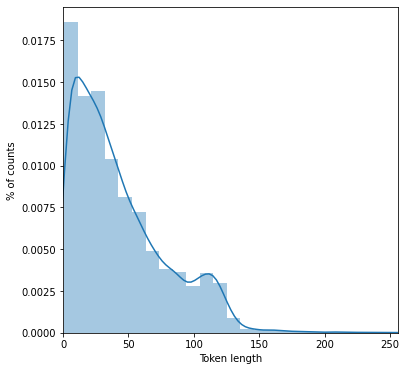

In [22]:
#Get the distribution plot
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token length')
plt.ylabel('% of counts')

We can take 128 as most of the token_length are less than 128

In [23]:
MAX_LEN = 128

### Create the class for Pytorch Dataset for apps reviews

In [24]:
class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [25]:
#Split the data into train and test
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [26]:
#Check the shapes
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

Create the data loader 

In [27]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
      )

In [28]:
#Create the data loaders
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [29]:
#Check the data loader
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [30]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


### As we have preprocessed the text, we will fine-tune BERT for sentiment analysis. Rather than using BERTForSequenceClassification or BERTForQuestionAnswering, we will use BERT model and build our own classifier

In [31]:
#Load the BERT Model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [32]:
#Encode the sample text
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

In [33]:
#Check the shape of last hidden state(Output of the last encoder of BERT)
last_hidden_state.shape

torch.Size([1, 32, 768])

As our length of example sentence is 32, we have hidden state of each token

In [34]:
#Pooling is applied using BertPooling for simplicity
pooled_output.shape

torch.Size([1, 768])

In [35]:
#We can check the number of hidden units in BERT using config
bert_model.config.hidden_size

768

#### Create a Sentiment Classifier

In [36]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

In [37]:
#Create instance
model = SentimentClassifier(len(class_name))
model = model.to(device)

In [38]:
#Move the example batch to GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [39]:
#Get the shape of input ids and attention masks
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 128])
torch.Size([16, 128])


In [40]:
#To get the predicted probability for each class, we will apply a softmax layer on the output
F.softmax(model(input_ids, attention_mask), dim = 1)

tensor([[0.4114, 0.1717, 0.4169],
        [0.5212, 0.1443, 0.3345],
        [0.3237, 0.1545, 0.5218],
        [0.4734, 0.1494, 0.3772],
        [0.5613, 0.1419, 0.2968],
        [0.3675, 0.2068, 0.4257],
        [0.4431, 0.1289, 0.4280],
        [0.2669, 0.2455, 0.4876],
        [0.3719, 0.1677, 0.4604],
        [0.3485, 0.1655, 0.4859],
        [0.4064, 0.1560, 0.4376],
        [0.4024, 0.1726, 0.4250],
        [0.5810, 0.0963, 0.3227],
        [0.4370, 0.1990, 0.3641],
        [0.3849, 0.1887, 0.4264],
        [0.3627, 0.2146, 0.4226]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Train the model

In [41]:
#Set the parameters for training as per recommendation by HuggingFace
EPOCHS = 4

#We will use AdamW optimizer 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
#Set the total steps
total_steps = len(train_data_loader) * EPOCHS

#Set the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [42]:
#Define a method for training the data
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    
    #Set the model in training mode
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        #Get the output
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        #Get the max of softmax
        _, preds = torch.max(outputs, dim=1)
        
        #Calculate the loss
        loss = loss_fn(outputs, targets)
        
        #Update loss and correct prediction
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        #Perform training actions
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)     #Normalize gradients to prevent explosion
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [43]:
#Define a method for evaluating the model
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [44]:
#Train the model for 4 epochs
from collections import defaultdict
#Define history and best accuracy
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    print(f'Epoch: {epoch + 1} / {EPOCHS}')
    print('-' * 15)

    #Call the train epoch method
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

    #Print the loss and accuracy
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')


    #Call the val epoch method
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

    #Print the validation loss and accuracy
    print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')


    #Update the history dictionary
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch: 1 / 4
---------------
Train loss: 0.7838702199488676, Train accuracy: 0.6346058852586268
Validation loss: 0.633722303211689, Validation accuracy: 0.7522236340533672
Epoch: 2 / 4
---------------
Train loss: 0.4997994578601141, Train accuracy: 0.8033307458894926
Validation loss: 0.5732557451725007, Validation accuracy: 0.7979669631512072
Epoch: 3 / 4
---------------
Train loss: 0.3056503171858043, Train accuracy: 0.8990896902124057
Validation loss: 0.554626961350441, Validation accuracy: 0.8348157560355782
Epoch: 4 / 4
---------------
Train loss: 0.20776728104955558, Train accuracy: 0.9364194481687954
Validation loss: 0.5867498637735844, Validation accuracy: 0.8513341804320204


(0.7, 1.0)

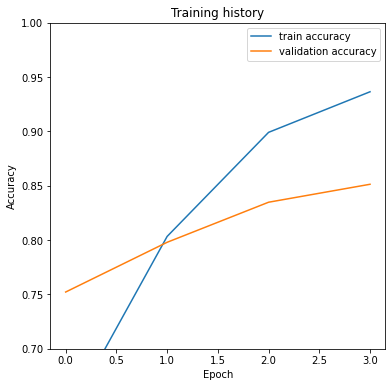

In [45]:
#PLot the graphs to compare accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.7, 1])

## Evaluation

In [46]:
test_accuracy = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print("Test accuracy: ", test_accuracy[0].item())

Test accuracy:  0.8629441624365481


## Function to get the predictions

In [47]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [48]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_name))

Beautiful UI/UX design. Very easy to navigate and the developers keep
adding useful features. If you're looking for an app with a to-do list
feature and a pomodoro timer, TickTick is a great choice. I don't use
the premium version and so far, I've still been able to access a lot
of features. I highly recommend this app.

True sentiment: positive


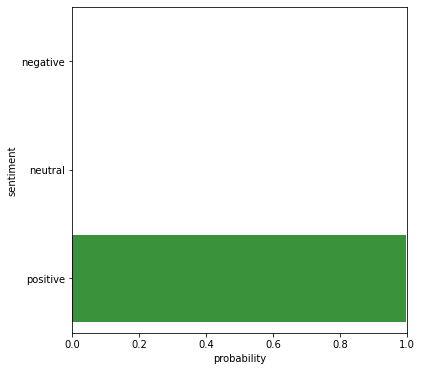

In [50]:
# Check sample
idx = 5
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({'class_name': class_name, 'values': y_pred_probs[idx]})
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_name[true_sentiment]}')
sns.barplot(x='values', y='class_name', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

## Prediction on user input

In [51]:
review_text = "I love NLP, it's the BEST"

In [52]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [53]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_name[prediction]}')

Review text: I love NLP, it's the BEST
Sentiment  : positive
Review text: I love NLP, it's the BEST
Sentiment  : positive
